# AE 370 Code document

To start lets establish the double pendulum system.

In [ ]:
# Constants (arbitrary values for testing)
m1, m2 = 1.0, 1.0  # masses
l1, l2 = 1.0, 1.0  # lengths
g = 9.81           # gravity

Lets compute the maximum timestep where the system will be stable.

In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.animation import FuncAnimation, FFMpegWriter
plt.rcParams.update({'font.size': 14})

# Define symbols
theta1, omega1, theta2, omega2 = sp.symbols('theta1 omega1 theta2 omega2')
M1, M2, L1, L2, G = sp.symbols('M1 M2 L1 L2 g')
y = sp.Matrix([theta1, omega1, theta2, omega2])

# Intermediate variables
delta = theta2 - theta1
sin_delta = sp.sin(delta)
cos_delta = sp.cos(delta)
sin_theta1 = sp.sin(theta1)
sin_theta2 = sp.sin(theta2)

denom = L1 * (M1 + M2 * sin_delta**2)

ddtheta1 = (
    -sin_delta * (M2 * L1 * omega1**2 * cos_delta + M2 * L2 * omega2**2)
    - G * ((M1 + M2) * sin_theta1 - M2 * sin_theta2 * cos_delta)
) / denom

ddtheta2 = (
    sin_delta * ((M1 + M2) * L1 * omega1**2 + M2 * L2 * omega2**2 * cos_delta)
    + G * ((M1 + M2) * sin_theta1 * cos_delta - (M1 + M2) * sin_theta2)
) / denom


f = sp.Matrix([omega1, ddtheta1, omega2, ddtheta2])
J = f.jacobian(y)

# Define an equilibrium point to linearlize about
eq_point = {
    theta1: 0, omega1: 0, theta2: 0, omega2: 0,
    sp.sin(0): 0, sp.cos(0): 1
}


# Constants (arbitrary values for testing)
params = {
    M1: m1, M2: m2, L1: l1, L2: l2, G: g
}

# Linearize and compute eigenvalues
subs = {**eq_point, **params}
J_eval = J.subs(subs).evalf()
eigenvals = J_eval.eigenvals()
print("Eigenvalues:")
for eigval in eigenvals:
    print(eigval)


Eigenvalues:
-5.78735129803609*I
-2.39719939786409*I
2.39719939786409*I
5.78735129803609*I


We will use the largest negative eignvalue to check for stability, and compute R as follows:
$$z = h\lambda$$
$$R(z) = 1+z+\frac{z^2}{2!} + \frac{z^3}{3!} + \frac{z^4}{4!}$$

The system is stable if:
$$|R(z)| \leq 1$$


In [205]:
h = 0.00001

while True:
    z = h * -5.78735129803609
    R = np.abs(1 + z + z**2/2 + z**3/(2*3) + z**4/(2*3*4))
    
    if R >= 1:
        h -= .00001  # Step back to the last valid h
        break
    
    h += .00001

print(f"Largest h such that R < 1: {h}")


Largest h such that R < 1: 0.48127000000034054


A time step of less that 0.48 seconds will be stable. However, the system is not being tested at a state near equilibrium, so the timestep may need to be lower.

Let's define the equations of motion and the Runge-Kutta 4th order numerical method (RK4) as a function.

In [ ]:
from numpy import sin
from numpy import cos

def equations(t, y):
    theta1, omega1, theta2, omega2 = y
    

    delta = theta2 - theta1

    sin_delta = np.sin(delta)
    cos_delta = np.cos(delta)
    sin_theta1 = np.sin(theta1)
    sin_theta2 = np.sin(theta2)

    
    # denom = l1 * (m1 + m2 * sin_delta**2)

    # ddtheta1 = (
    #     -sin_delta * (m2 * l1 * omega1**2 * cos_delta + m2 * l2 * omega2**2)
    #     - g * ((m1 + m2) * sin_theta1 - m2 * sin_theta2 * cos_delta)
    # ) / denom

    # ddtheta2 = (
    #     sin_delta * ((m1 + m2) * l1 * omega1**2 + m2 * l2 * omega2**2 * cos_delta)
    #     + g * ((m1 + m2) * sin_theta1 * cos_delta - (m1 + m2) * sin_theta2)
    # ) / denom

    denom = l1*(2*m1 + m2 - m2*cos(2*theta1 - 2*theta2))
    ddtheta1 = (
        -g*(2*m1 + m2)*sin(theta1) - m2*g*sin(theta1-2*theta2) - 2*sin(theta1-theta2)*m2*(omega2**2*l2 + omega1**2*l1*cos(theta1-theta2))
    ) / denom

    ddtheta2 = (
        2*sin(theta1 - theta2)*(omega1**2*l1*(m1 + m2) + g*(m1 + m2)*cos(theta1) + omega2**2*l2*m2*cos(theta1 - theta2))
    ) / denom

    return np.array([omega1, ddtheta1, omega2, ddtheta2])

def rk4_step(f, t, y, dt):
    k1 = dt * f(t, y)
    k2 = dt * f(t + dt / 2, y + k1 / 2)
    k3 = dt * f(t + dt / 2, y + k2 / 2)
    k4 = dt * f(t + dt, y + k3)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6

def solve_rk4(y0, dt, t_max):
    t_values = np.arange(0, t_max, dt)
    y_values = np.zeros((len(t_values), len(y0)))
    y_values[0] = y0 

    for i in range(1, len(t_values)):
        y_values[i] = rk4_step(equations, t_values[i-1], y_values[i-1], dt)

    return t_values, y_values

## Error and State Analyis

Set ```reduce_analysis``` to ```False``` to run the full analysis, otherwise a reduced resolution one will run.

In [207]:
reduce_analysis = True

In [208]:
def compare_full_state_error(y0, t_max, dt_list, t_ref, y_ref):
    """Since no know analytical solution exists for the double pendulum system,
    we must use a much more accurate numerical approximation to get our reference solution.
    This leads to an issue where gaps in the reference solution exists.
    To overcome this, when there is no exact reference point avaiable to compare to,
    one is interpolated from the known reference solution."""
    
    interp_ref = interp1d(t_ref, y_ref, axis=0, kind='cubic')

    errors = []

    for dt in dt_list:
        t_test = np.arange(0, t_max, dt)
        t_test, y_test = solve_rk4(y0, dt, t_max)
        
        # Interpolate reference to match test time points
        y_ref_interp = interp_ref(t_test)
        error = np.linalg.norm(y_test - y_ref_interp, axis=1)  # norm at each time step
        mean_error = np.mean(error)  # average over the trajectory
        errors.append(mean_error)

    # Create and align reference line
    x_anchor = dt_list[1]
    y_anchor = errors[1]
    ref_error_x = np.array(dt_list)
    ref_error_y = (ref_error_x / x_anchor)**4 * y_anchor

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.loglog(ref_error_x, ref_error_y, '--', label='Reference Slope $O(dt^4)$')
    plt.loglog(dt_list, errors, 'o-', label="RK4 Error")
    plt.xlabel("Time Step (dt)")
    plt.ylabel("Mean Full State Error (2-norm)")
    plt.title("Error vs Time Step for RK4")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()


Compute the reference soultion.

In [209]:
# Time parameters
t_max = 30  # simulation time in seconds
dt_rk4 = 0.01  # RK4 time step

# Initial conditions: [theta1, omega1, theta2, omega2]
y0 = np.array([np.pi/2, 0, 0, 0])

# Reference solution time step
if reduce_analysis:
    dt_ref = .0001
else:
    dt_ref = 0.00001

t_ref, y_ref = solve_rk4(y0, dt_ref, t_max)

Compute the error reduction as dt decreases.

C:\Users\jelly\AppData\Local\Temp\ipykernel_8932\1351804023.py:35: RuntimeWarning: overflow encountered in scalar power
  -g*(2*m1 + m2)*sin(theta1) - m2*g*sin(theta1-2*theta2) - 2*sin(theta1-theta2)*m2*(omega2**2*l2 + omega1**2*l1*cos(theta1-theta2))
C:\Users\jelly\AppData\Local\Temp\ipykernel_8932\1351804023.py:39: RuntimeWarning: overflow encountered in scalar power
  2*sin(theta1 - theta2)*(omega1**2*l1*(m1 + m2) + g*(m1 + m2)*cos(theta1) + omega2**2*l2*m2*cos(theta1 - theta2))
C:\Users\jelly\AppData\Local\Temp\ipykernel_8932\1351804023.py:35: RuntimeWarning: invalid value encountered in scalar add
  -g*(2*m1 + m2)*sin(theta1) - m2*g*sin(theta1-2*theta2) - 2*sin(theta1-theta2)*m2*(omega2**2*l2 + omega1**2*l1*cos(theta1-theta2))
C:\Users\jelly\AppData\Local\Temp\ipykernel_8932\1351804023.py:39: RuntimeWarning: invalid value encountered in scalar add
  2*sin(theta1 - theta2)*(omega1**2*l1*(m1 + m2) + g*(m1 + m2)*cos(theta1) + omega2**2*l2*m2*cos(theta1 - theta2))
C:\Users\jelly\AppDa

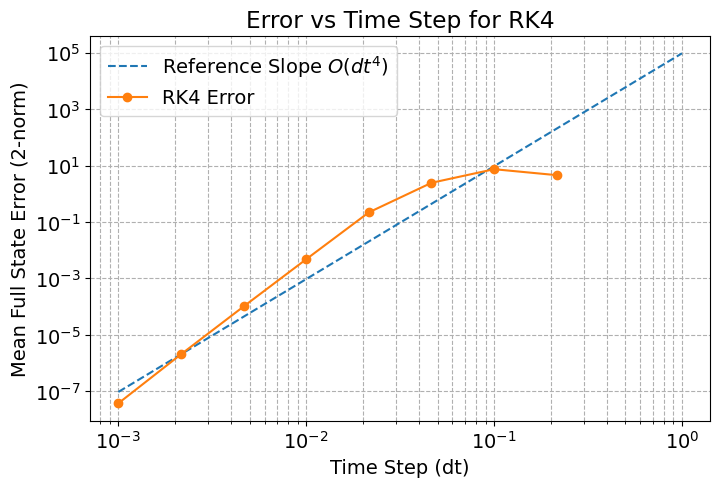

In [210]:
if reduce_analysis:
    dt_values = np.logspace(-3,0,10)
else:
    dt_values = np.logspace(-4, 0, 15)
compare_full_state_error(y0, t_max, dt_values, t_ref, y_ref)

## Plot the etate error for on time step

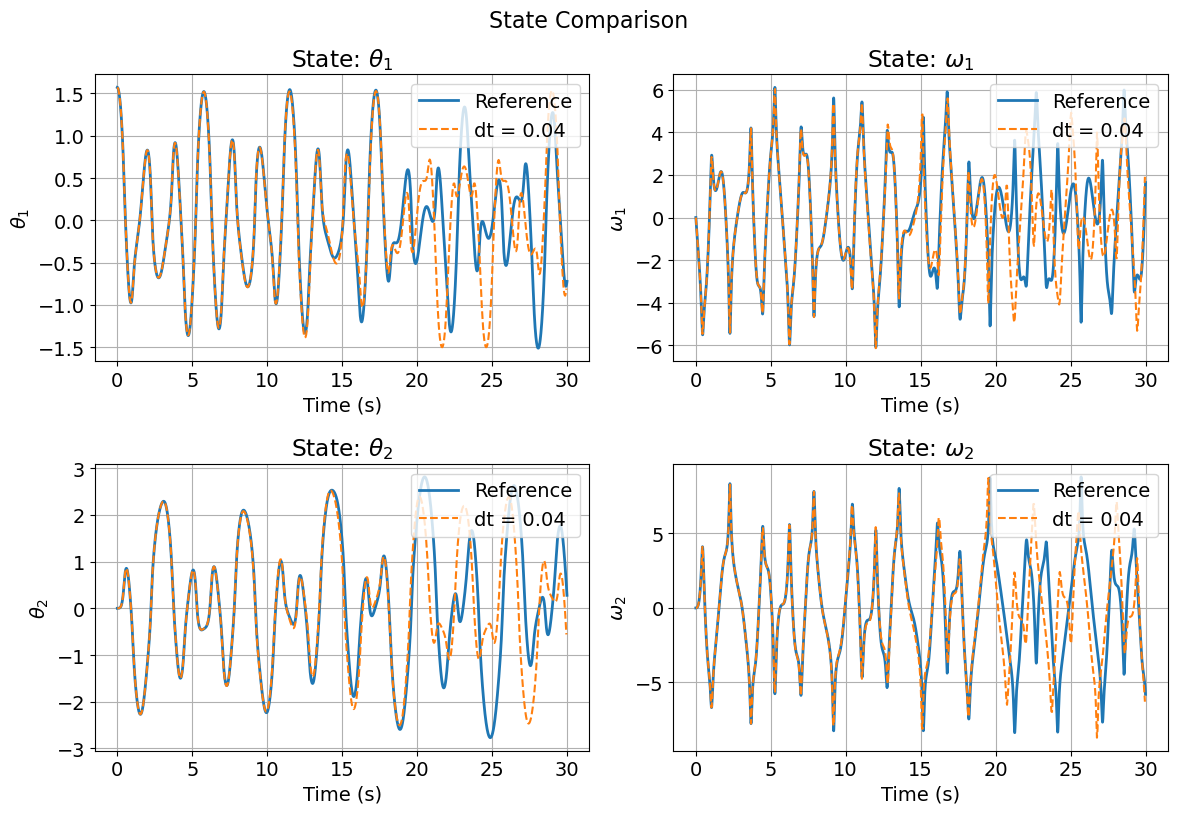

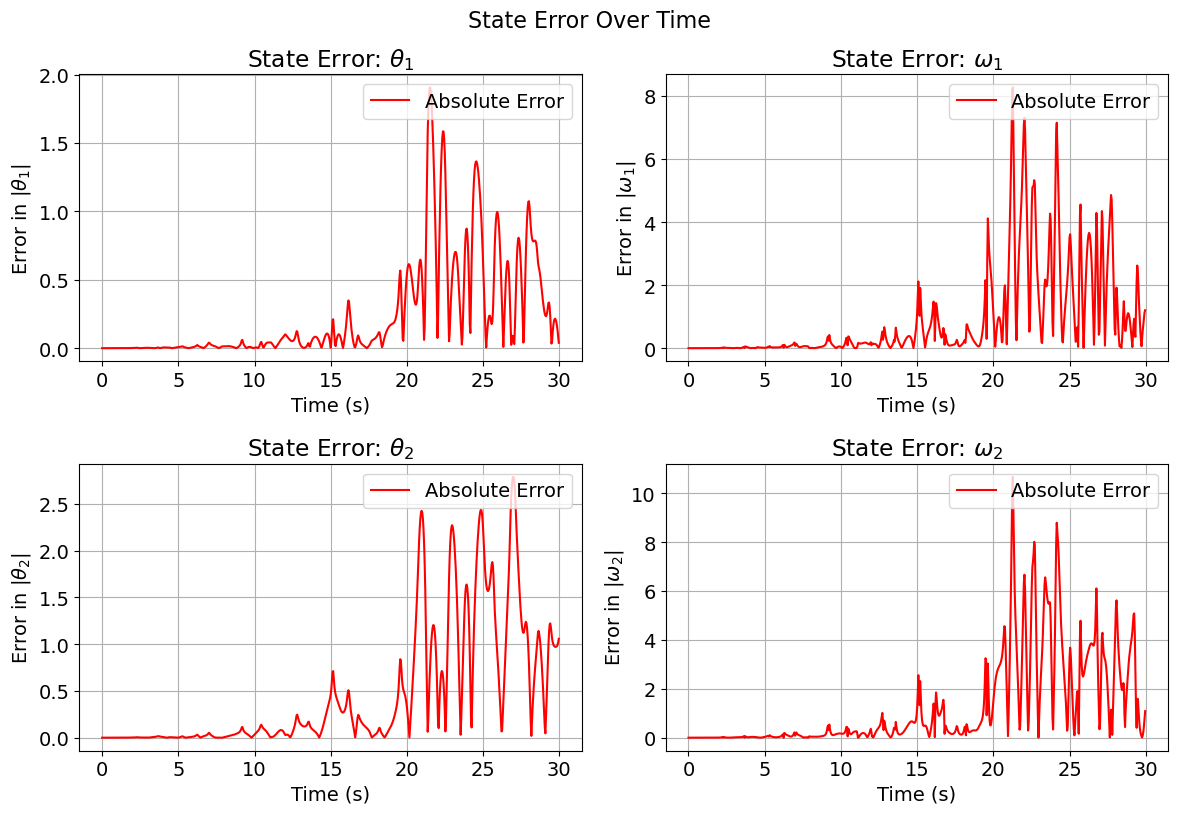

In [211]:
dt_n = 0.04  # Comparison dt

t_n, y_n = solve_rk4(y0, dt_n, t_max)

# Plot the state variables
labels = [r'$\theta_1$', r'$\omega_1$', r'$\theta_2$', r'$\omega_2$']
plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(t_ref, y_ref[:, i], label='Reference', linewidth=2)
    plt.plot(t_n, y_n[:, i], '--', label=f'dt = {dt_n}', linewidth=1.5)
    plt.xlabel('Time (s)')
    plt.ylabel(labels[i])
    plt.title(f'State: {labels[i]}')
    plt.grid(True)
    plt.legend(loc='upper right')

plt.tight_layout()
plt.suptitle('State Comparison', fontsize=16, y=1.02)
plt.show()

# Interpolate y_ref to match the time steps of y_n
y_ref_interp = np.zeros_like(y_n)
for i in range(y_ref.shape[1]):
    interp_func = interp1d(t_ref, y_ref[:, i], kind='cubic', fill_value="extrapolate")
    y_ref_interp[:, i] = interp_func(t_n)
errors = np.abs(y_n - y_ref_interp)

plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(t_n, errors[:, i], color='red', label='Absolute Error')
    plt.xlabel('Time (s)')
    plt.ylabel(f'Error in |{labels[i]}|')
    plt.title(f'State Error: {labels[i]}')
    plt.grid(True)
    plt.legend(loc='upper right')

plt.tight_layout()
plt.suptitle('State Error Over Time', fontsize=16, y=1.02)
plt.show()


To see the behavior of the system be, lets analyze how the total energy of the system changes over time.

In [227]:
def total_energy(state, params):
    theta1, omega1, theta2, omega2 = state
    m1, m2, l1, l2, g = params

    KE = 0.5 * (m1+m2) * l1**2 * omega1**2 + 0.5 * m2 * l2**2 * omega2**2 + m2*l1*l2*omega1*omega2*np.cos(theta1-theta2)
    PE = -(m1+m2) * g * l1 * np.cos(theta1) - m2*g*l2*np.cos(theta2)
    return np.abs(KE + PE)


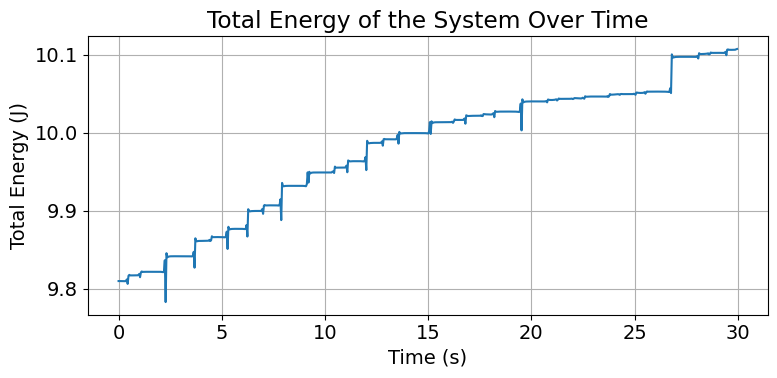

In [ ]:
params = m1, m2, l1, l2, g

# Compute total energy at each time step
energy = np.array([total_energy(state, params) for state in y_n])

# Plot total energy over time
plt.figure(figsize=(8, 4))
plt.plot(t_n, energy)
plt.xlabel('Time (s)')
plt.ylabel('Total Energy (J)')
plt.title('Total Energy of the System Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


For fun lets also visuialize the motion of the pendulum with a video. Courtesy of ChatGPT: [https://chatgpt.com/share/67f8c5da-52c4-800e-a62f-dec4a68f8c22](https://chatgpt.com/share/67f8c5da-52c4-800e-a62f-dec4a68f8c22)

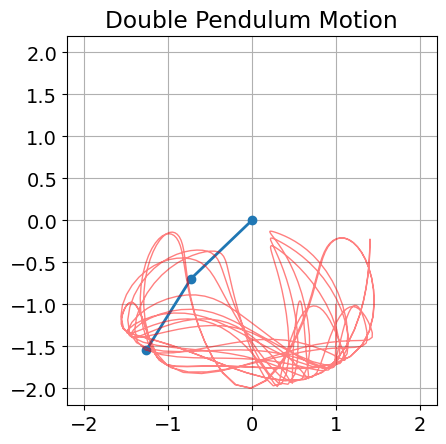

In [229]:
# Extract theta1 and theta2
theta1 = y_n[:, 0]
theta2 = y_n[:, 2]

# Convert to Cartesian coordinates
x1 = l1 * np.sin(theta1)
y1 = -l1 * np.cos(theta1)
x2 = x1 + l2 * np.sin(theta2)
y2 = y1 - l2 * np.cos(theta2)

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-2.2, 2.2)
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
trace, = ax.plot([], [], '-', lw=1, alpha=0.5, color='red')
path_x, path_y = [], []

def init():
    line.set_data([], [])
    trace.set_data([], [])
    return line, trace

def update(i):
    line.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
    path_x.append(x2[i])
    path_y.append(y2[i])
    trace.set_data(path_x, path_y)
    return line, trace

ani = FuncAnimation(fig, update, frames=len(t_n), init_func=init,
                    interval=dt_n * 1000, blit=True)

# Save the animation
writer = FFMpegWriter(fps=int(1 / dt_n), metadata=dict(artist='Double Pendulum Sim'))
ani.save("double_pendulum.mp4", writer=writer)

plt.title("Double Pendulum Motion")
plt.show()
